In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
except:
    print("Mounting Failed.")

Mounted at /content/drive/


In [2]:
path = "/content/drive/My Drive/Colab Notebooks/model.csv"

In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn


In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [5]:
df = pd.read_csv(path, index_col="TIME")
df.head()

,Unnamed: 0,BIOGAS,BIOMASS,GEOTHERMAL,SMALL HYDRO,SOLAR,WIND TOTAL
TIME,,,,,,,
2010-04-20,0,3803.0,7491.0,25594.0,6571.0,1410.0,23746.0
2010-04-21,1,3996.0,6797.0,25731.0,7014.0,414.0,20842.0
2010-04-22,2,4158.0,6907.0,25811.0,6921.0,481.0,8696.0
2010-04-23,3,4170.0,7508.0,25327.0,7089.0,3284.0,16501.0
2010-04-24,4,4278.0,7146.0,25203.0,6987.0,3371.0,17063.0


# SOLAR

In [6]:
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()

df = df.rename(columns={"SOLAR": "value"})
df = df["value"].to_frame()
df.head()

,value
TIME,
2010-04-20,1410.0
2010-04-21,414.0
2010-04-22,481.0
2010-04-23,3284.0
2010-04-24,3371.0


In [7]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

df_generated_solar = generate_time_lags(df, 100)
df_generated_solar.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,4102.0,4438.0,4686.0,4328.0,2214.0,3320.0,5076.0,5081.0,5132.0,4293.0,...,3330.0,2231.0,2049.0,3599.0,3376.0,3371.0,3284.0,481.0,414.0,1410.0
2010-07-30,3847.0,4102.0,4438.0,4686.0,4328.0,2214.0,3320.0,5076.0,5081.0,5132.0,...,3762.0,3330.0,2231.0,2049.0,3599.0,3376.0,3371.0,3284.0,481.0,414.0
2010-07-31,3596.0,3847.0,4102.0,4438.0,4686.0,4328.0,2214.0,3320.0,5076.0,5081.0,...,3416.0,3762.0,3330.0,2231.0,2049.0,3599.0,3376.0,3371.0,3284.0,481.0
2010-08-01,1990.0,3596.0,3847.0,4102.0,4438.0,4686.0,4328.0,2214.0,3320.0,5076.0,...,3438.0,3416.0,3762.0,3330.0,2231.0,2049.0,3599.0,3376.0,3371.0,3284.0
2010-08-02,3137.0,1990.0,3596.0,3847.0,4102.0,4438.0,4686.0,4328.0,2214.0,3320.0,...,3591.0,3438.0,3416.0,3762.0,3330.0,2231.0,2049.0,3599.0,3376.0,3371.0


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
def scale(df_generated):
    temp = df_generated.drop(columns=["value"])
    scaled = pd.DataFrame(scaler.fit_transform(temp.T).T,columns=temp.columns)
    temp2 = df_generated[["value"]].reset_index()
    temp3 = pd.concat([scaled, temp2], axis=1)
    scaled_lag = temp3.set_index("TIME")
    return scaled_lag

scaled_lag_solar = scale(df_generated_solar)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


In [9]:
df_features = (
                df
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year = df.index.week)
              )
df_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,value,day,month,day_of_week,week_of_year
TIME,,,,,
2010-04-20,1410.0,20,4,1,16
2010-04-21,414.0,21,4,2,16
2010-04-22,481.0,22,4,3,16
2010-04-23,3284.0,23,4,4,16
2010-04-24,3371.0,24,4,5,16
...,...,...,...,...,...
2018-01-12,2494.0,12,1,4,2
2018-01-13,2630.0,13,1,5,2
2018-01-14,1650.0,14,1,6,2


In [10]:
month = pd.get_dummies(df_features["month"], prefix="month")
day = pd.get_dummies(df_features["day"], prefix="day")
day_of_week = pd.get_dummies(df_features["day_of_week"], prefix="day_of_week")
week_of_year = pd.get_dummies(df_features["week_of_year"], prefix="week_of_year")

df_features = pd.concat([df_features, month, day, day_of_week, week_of_year], axis=1).drop(columns=["day","month","day_of_week","week_of_year"])

In [11]:
from datetime import date
import holidays

us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))


df_features = add_holiday_col(df_features, us_holidays)
df_features

,value,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,is_holiday
TIME,,,,,,,,,,,,,,,,,,,,,
2010-04-20,1410.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-04-21,414.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-04-22,481.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-04-23,3284.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-04-24,3371.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,2494.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-13,2630.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-14,1650.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
months = df.assign(month = df.index.month)
seasons = months["month"] % 12 // 3 + 1
temp = pd.get_dummies(seasons, prefix="season")
df_features = pd.concat([df_features, temp], axis=1)

In [13]:
# Solar
solar_combined = pd.concat([df_features, scaled_lag_solar.drop(columns="value")], axis=1)
solar_combined.dropna(inplace=True)
solar_combined

,value,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,4102.0,0,0,0,0,0,0,1,0,0,...,-0.388430,-1.296694,-1.447107,-0.166116,-0.350413,-0.354545,-0.426446,-2.742975,-2.798347,-1.975207
2010-07-30,3847.0,0,0,0,0,0,0,1,0,0,...,-0.064051,-0.430541,-1.362884,-1.517285,-0.202333,-0.391516,-0.395758,-0.469565,-2.847508,-2.904348
2010-07-31,3596.0,0,0,0,0,0,0,1,0,0,...,-0.384832,-0.084940,-0.459372,-1.411918,-1.569664,-0.226219,-0.419502,-0.423835,-0.499242,-2.928711
2010-08-01,1990.0,0,0,0,0,0,0,0,1,0,...,-0.367596,-0.386760,-0.085366,-0.461672,-1.418990,-1.577526,-0.227352,-0.421603,-0.425958,-0.501742
2010-08-02,3137.0,0,0,0,0,0,0,0,1,0,...,-0.234321,-0.367596,-0.386760,-0.085366,-0.461672,-1.418990,-1.577526,-0.227352,-0.421603,-0.425958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,2494.0,1,0,0,0,0,0,0,0,0,...,0.925033,0.792923,0.472084,1.199738,1.143119,1.108519,1.180341,1.245872,1.217562,1.116907
2018-01-13,2630.0,1,0,0,0,0,0,0,0,0,...,1.071703,0.935454,0.801856,0.477402,1.213254,1.155997,1.121007,1.193638,1.259907,1.231279
2018-01-14,1650.0,1,0,0,0,0,0,0,0,0,...,1.227503,1.079573,0.942323,0.807744,0.480908,1.222163,1.164486,1.129239,1.202403,1.269159


Train Test Split for Solar

In [14]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(solar_combined, 'value', 0.2)


y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

RNN Structure



In [16]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim*2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim*2),
            nn.Linear(hidden_dim*2, output_dim)
        )
        
    
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        return self.fc(out)

In [17]:
from datetime import datetime
import matplotlib.pyplot as plt
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'RNN_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values


    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

Training


[1/200] Training loss: 0.6359	 Validation loss: 0.3714
[2/200] Training loss: 0.5451	 Validation loss: 0.3595
[3/200] Training loss: 0.5188	 Validation loss: 0.3573
[4/200] Training loss: 0.5102	 Validation loss: 0.3441
[5/200] Training loss: 0.4943	 Validation loss: 0.3399
[6/200] Training loss: 0.4817	 Validation loss: 0.3227
[7/200] Training loss: 0.4766	 Validation loss: 0.3442
[8/200] Training loss: 0.4718	 Validation loss: 0.3328
[9/200] Training loss: 0.4668	 Validation loss: 0.3134
[10/200] Training loss: 0.4622	 Validation loss: 0.3022
[50/200] Training loss: 0.4090	 Validation loss: 0.2738
[100/200] Training loss: 0.3956	 Validation loss: 0.2715
[150/200] Training loss: 0.3894	 Validation loss: 0.2598
[200/200] Training loss: 0.3884	 Validation loss: 0.2661


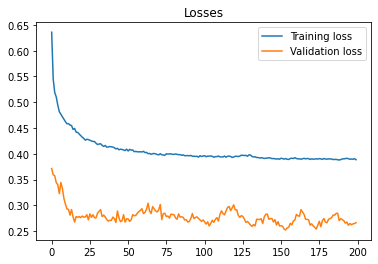

In [18]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [19]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
#df_result = pd.DataFrame(data={"value": values, "prediction": predictions}, index=X_test.head(len(values)).index)

In [20]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

RMSE error in test dataset is 1533.8060302734375


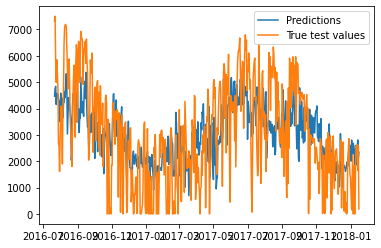

In [21]:
plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

Forecasting

In [43]:
def future_features_func():
    future = pd.read_csv("/content/drive/My Drive/Colab Notebooks/futuredates.csv", index_col="TIME")

    future.index = pd.to_datetime(future.index)
    if not df.index.is_monotonic:
        future = future.sort_index()

    future_features = (
                    future
                    .assign(day = future.index.day)
                    .assign(month = future.index.month)
                    .assign(day_of_week = future.index.dayofweek)
                    .assign(week_of_year = future.index.week)
                )

    month = pd.get_dummies(future_features["month"], prefix="month")
    day = pd.get_dummies(future_features["day"], prefix="day")
    day_of_week = pd.get_dummies(future_features["day_of_week"], prefix="day_of_week")
    week_of_year = pd.get_dummies(future_features["week_of_year"], prefix="week_of_year")

    future_features = pd.concat([future_features, month, day, day_of_week, week_of_year], axis=1).drop(columns=["day","month","day_of_week","week_of_year"])
    #holidays
    future_features = add_holiday_col(future_features, us_holidays)

    # Season
    months = future.assign(month = future.index.month)
    seasons = months["month"] % 12 // 3 + 1
    temp = pd.get_dummies(seasons, prefix="season")
    future_features = pd.concat([future_features, temp], axis=1)

    return future_features

In [44]:
future_features = future_features_func()
solar_future_lag1 = df_generated_solar.iloc[-1].to_frame().T.drop(columns="value")
s = pd.DataFrame(scaler.fit_transform(solar_future_lag1.T).T, columns=solar_future_lag1.columns)

future_features =  pd.concat([future_features.reset_index(), s], axis=1)
future_features = future_features.set_index("TIME")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


In [45]:
for i, date in enumerate(future_features.index):
    if i == 0:
        continue
    x = future_features.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    future_features.iat[i,107] = predictions[0]
    for j in range(2,102):
        future_features.iat[i,j+106] = future_features.iat[i-1, j+105]

In [46]:
solar_forecast = scaler.inverse_transform(future_features["lag1"].to_numpy().reshape(-1,1))
sol_df = pd.DataFrame(solar_forecast)
sol_df.to_csv("/content/drive/My Drive/Colab Notebooks/sol.csv")

Solar is done :)

# BIOGAS

In [47]:
df = pd.read_csv(path, index_col="TIME")
df.index = pd.to_datetime(df.index)

if not df.index.is_monotonic:
    df = df.sort_index()

df_bio = df.rename(columns={"BIOGAS": "value"})
df_bio = df_bio["value"].to_frame()

df_generated_biogas = generate_time_lags(df_bio, 100)
df_generated_biogas.head()

scaled_lagged_biogas = scale(df_generated_biogas)
scaled_lagged_biogas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100,value
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,-0.271041,-0.322397,0.014265,-1.429387,-0.031384,-0.368046,-0.094151,-0.042796,-0.385164,0.219686,...,-0.459344,0.282454,0.801712,0.413695,1.537803,0.921541,0.853067,-0.071327,-1.172611,3996.0
2010-07-30,-0.078864,-0.299685,-0.356467,0.015773,-1.580442,-0.034700,-0.406940,-0.104101,-0.047319,-0.425868,...,-0.501577,-0.507886,0.312303,0.886435,0.457413,1.700315,1.018927,0.943218,-0.078864,4053.0
2010-07-31,0.271293,-0.088328,-0.309148,-0.365931,0.006309,-1.589905,-0.044164,-0.416404,-0.113565,-0.056782,...,0.391167,-0.511041,-0.517350,0.302839,0.876972,0.447950,1.690852,1.009464,0.933754,4032.0
2010-08-01,0.139905,0.273450,-0.089030,-0.311606,-0.368839,0.006359,-1.602544,-0.044515,-0.419714,-0.114467,...,0.661367,0.394277,-0.515103,-0.521463,0.305246,0.883943,0.451510,1.704293,1.017488,3969.0
2010-08-02,-0.255250,0.151858,0.287561,-0.080775,-0.306947,-0.365105,0.016155,-1.618740,-0.035541,-0.416801,...,0.630048,0.681745,0.410339,-0.513732,-0.520194,0.319871,0.907916,0.468498,1.741519,3965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,0.336359,-1.374104,-1.414238,-0.923077,-1.009078,-0.934544,-0.940277,-1.010989,-0.879121,-0.741519,...,-0.437649,-0.959388,0.074534,0.013378,0.034400,0.194935,0.238892,-2.094601,-3.864310,5787.0
2018-01-13,0.506058,0.315937,-1.352283,-1.391426,-0.912395,-0.996272,-0.923579,-0.929171,-0.998136,-0.869525,...,0.023299,-0.438956,-0.947810,0.060578,0.000932,0.021435,0.178006,0.220876,-2.054986,5632.0
2018-01-14,0.210476,0.505714,0.311429,-1.393333,-1.433333,-0.943810,-1.029524,-0.955238,-0.960952,-1.031429,...,0.160952,0.012381,-0.460000,-0.980000,0.050476,-0.010476,0.010476,0.170476,0.214286,5716.0


In [48]:
biogas_combined = pd.concat([df_features, scaled_lagged_biogas.drop(columns="value")], axis=1)
biogas_combined.dropna(inplace=True)
biogas_combined

,value,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,4102.0,0,0,0,0,0,0,1,0,0,...,-0.453638,-0.459344,0.282454,0.801712,0.413695,1.537803,0.921541,0.853067,-0.071327,-1.172611
2010-07-30,3847.0,0,0,0,0,0,0,1,0,0,...,0.400631,-0.501577,-0.507886,0.312303,0.886435,0.457413,1.700315,1.018927,0.943218,-0.078864
2010-07-31,3596.0,0,0,0,0,0,0,1,0,0,...,0.656151,0.391167,-0.511041,-0.517350,0.302839,0.876972,0.447950,1.690852,1.009464,0.933754
2010-08-01,1990.0,0,0,0,0,0,0,0,1,0,...,0.610493,0.661367,0.394277,-0.515103,-0.521463,0.305246,0.883943,0.451510,1.704293,1.017488
2010-08-02,3137.0,0,0,0,0,0,0,0,1,0,...,0.487884,0.630048,0.681745,0.410339,-0.513732,-0.520194,0.319871,0.907916,0.468498,1.741519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,2494.0,1,0,0,0,0,0,0,0,0,...,0.036312,-0.437649,-0.959388,0.074534,0.013378,0.034400,0.194935,0.238892,-2.094601,-3.864310
2018-01-13,2630.0,1,0,0,0,0,0,0,0,0,...,0.168686,0.023299,-0.438956,-0.947810,0.060578,0.000932,0.021435,0.178006,0.220876,-2.054986
2018-01-14,1650.0,1,0,0,0,0,0,0,0,0,...,-0.722857,0.160952,0.012381,-0.460000,-0.980000,0.050476,-0.010476,0.010476,0.170476,0.214286


In [49]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(biogas_combined, 'value', 0.2)


y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

[1/200] Training loss: 0.6539	 Validation loss: 0.4766
[2/200] Training loss: 0.5515	 Validation loss: 0.4601
[3/200] Training loss: 0.5276	 Validation loss: 0.4551
[4/200] Training loss: 0.5124	 Validation loss: 0.4167
[5/200] Training loss: 0.4981	 Validation loss: 0.4062
[6/200] Training loss: 0.4965	 Validation loss: 0.4242
[7/200] Training loss: 0.4938	 Validation loss: 0.3852
[8/200] Training loss: 0.4801	 Validation loss: 0.3814
[9/200] Training loss: 0.4738	 Validation loss: 0.3836
[10/200] Training loss: 0.4722	 Validation loss: 0.3875
[50/200] Training loss: 0.4190	 Validation loss: 0.3314
[100/200] Training loss: 0.3968	 Validation loss: 0.3256
[150/200] Training loss: 0.3943	 Validation loss: 0.3144
[200/200] Training loss: 0.3898	 Validation loss: 0.3250


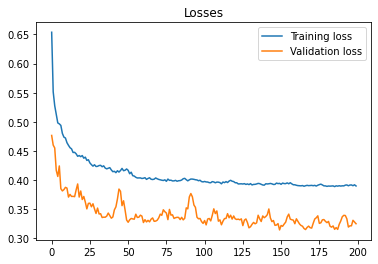

In [50]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [51]:
RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

RMSE error in test dataset is 1533.8060302734375


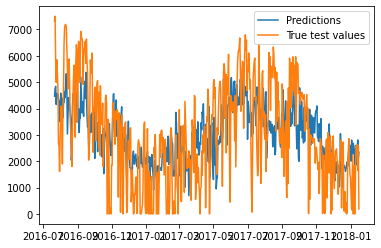

In [52]:
plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

In [67]:
bg_ff = future_features_func()

biog_future_lag1 = df_generated_biogas.iloc[-1].to_frame().T.drop(columns="value")
b = pd.DataFrame(scaler.fit_transform(biog_future_lag1.T).T, columns=biog_future_lag1.columns)

bg_ff = pd.concat([bg_ff.reset_index(), b], axis=1)
bg_ff = bg_ff.set_index("TIME")
bg_ff["week_of_year_53"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


In [68]:
for i, date in enumerate(bg_ff.index):
    if i == 0:
        continue
    x = bg_ff.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    bg_ff.iat[i,107] = predictions[0]
    for j in range(2,102):
        bg_ff.iat[i,j+106] = bg_ff.iat[i-1, j+105]

bg_forecast = scaler.inverse_transform(bg_ff["lag1"].to_numpy().reshape(-1,1))
bg_f_df = pd.DataFrame(bg_forecast)
bg_f_df.to_csv("/content/drive/My Drive/Colab Notebooks/bg.csv")

# BIOMASS

In [55]:
df = pd.read_csv(path, index_col="TIME")
df.index = pd.to_datetime(df.index)

if not df.index.is_monotonic:
    df = df.sort_index()

df_biomass = df.rename(columns={"BIOMASS": "value"})
df_biomass = df_biomass["value"].to_frame()

df_generated_biomass = generate_time_lags(df_biomass, 100)
df_generated_biomass.head()

scaled_lagged_biomass = scale(df_generated_biomass)
scaled_lagged_biomass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100,value
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,0.741312,0.642569,0.372199,0.140915,0.269341,0.610536,0.635809,0.784219,0.800676,0.800382,...,-0.227316,-0.194695,-0.271692,-0.196459,-0.137977,-0.031592,-0.208214,-0.240541,-0.036588,10293.0
2010-07-30,0.732264,0.686873,0.588476,0.319057,0.088586,0.216561,0.556556,0.581741,0.729629,0.746028,...,-0.295044,-0.278351,-0.245845,-0.322571,-0.247602,-0.189326,-0.083315,-0.259316,-0.291529,9543.0
2010-07-31,0.475964,0.691854,0.647237,0.550518,0.285694,0.059154,0.184945,0.519142,0.543898,0.689263,...,-0.582470,-0.317933,-0.301526,-0.269574,-0.344991,-0.271301,-0.214018,-0.109816,-0.282815,8305.0
2010-08-01,0.112694,0.469056,0.684945,0.640328,0.543610,0.278785,0.052245,0.178037,0.512234,0.536989,...,-0.756045,-0.589378,-0.324842,-0.308434,-0.276482,-0.351900,-0.278210,-0.220927,-0.116724,9268.0
2010-08-02,0.370322,0.093120,0.449482,0.665371,0.620754,0.524036,0.259211,0.032671,0.158463,0.492660,...,-0.640616,-0.775619,-0.608952,-0.344416,-0.328008,-0.296056,-0.371474,-0.297784,-0.240501,8793.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,-0.826311,-0.847846,-0.960206,-0.408708,0.084738,0.333801,0.557584,-0.258895,-0.039794,0.547285,...,-0.839419,-0.658708,-1.007959,-1.019195,-2.240169,-1.383427,0.343165,0.185861,0.025749,7475.0
2018-01-13,-0.493446,-0.800562,-0.822097,-0.934457,-0.382959,0.110487,0.359551,0.583333,-0.233146,-0.014045,...,-0.232210,-0.813670,-0.632959,-0.982210,-0.993446,-2.214419,-1.357678,0.368914,0.211610,7545.0
2018-01-14,-0.375468,-0.441011,-0.748127,-0.769663,-0.882022,-0.330524,0.162921,0.411985,0.635768,-0.180712,...,-1.007491,-0.179775,-0.761236,-0.580524,-0.929775,-0.941011,-2.161985,-1.305243,0.421348,7584.0


In [56]:
biomass_combined = pd.concat([df_features, scaled_lagged_biomass.drop(columns="value")], axis=1)
biomass_combined.dropna(inplace=True)
biomass_combined

,value,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
TIME,,,,,,,,,,,,,,,,,,,,,
2010-07-29,4102.0,0,0,0,0,0,0,1,0,0,...,-0.244067,-0.227316,-0.194695,-0.271692,-0.196459,-0.137977,-0.031592,-0.208214,-0.240541,-0.036588
2010-07-30,3847.0,0,0,0,0,0,0,1,0,0,...,-0.564170,-0.295044,-0.278351,-0.245845,-0.322571,-0.247602,-0.189326,-0.083315,-0.259316,-0.291529
2010-07-31,3596.0,0,0,0,0,0,0,1,0,0,...,-0.749136,-0.582470,-0.317933,-0.301526,-0.269574,-0.344991,-0.271301,-0.214018,-0.109816,-0.282815
2010-08-01,1990.0,0,0,0,0,0,0,0,1,0,...,-0.621042,-0.756045,-0.589378,-0.324842,-0.308434,-0.276482,-0.351900,-0.278210,-0.220927,-0.116724
2010-08-02,3137.0,0,0,0,0,0,0,0,1,0,...,-0.627087,-0.640616,-0.775619,-0.608952,-0.344416,-0.328008,-0.296056,-0.371474,-0.297784,-0.240501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-12,2494.0,1,0,0,0,0,0,0,0,0,...,-0.257959,-0.839419,-0.658708,-1.007959,-1.019195,-2.240169,-1.383427,0.343165,0.185861,0.025749
2018-01-13,2630.0,1,0,0,0,0,0,0,0,0,...,-1.059925,-0.232210,-0.813670,-0.632959,-0.982210,-0.993446,-2.214419,-1.357678,0.368914,0.211610
2018-01-14,1650.0,1,0,0,0,0,0,0,0,0,...,-1.190075,-1.007491,-0.179775,-0.761236,-0.580524,-0.929775,-0.941011,-2.161985,-1.305243,0.421348


In [57]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(biomass_combined, 'value', 0.2)


y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

[1/200] Training loss: 0.6374	 Validation loss: 0.4835
[2/200] Training loss: 0.5452	 Validation loss: 0.4563
[3/200] Training loss: 0.5314	 Validation loss: 0.4500
[4/200] Training loss: 0.5150	 Validation loss: 0.4283
[5/200] Training loss: 0.5004	 Validation loss: 0.4063
[6/200] Training loss: 0.4918	 Validation loss: 0.4135
[7/200] Training loss: 0.4785	 Validation loss: 0.3827
[8/200] Training loss: 0.4769	 Validation loss: 0.3814
[9/200] Training loss: 0.4685	 Validation loss: 0.3832
[10/200] Training loss: 0.4699	 Validation loss: 0.3757
[50/200] Training loss: 0.4129	 Validation loss: 0.3519
[100/200] Training loss: 0.3985	 Validation loss: 0.3402
[150/200] Training loss: 0.3950	 Validation loss: 0.3473
[200/200] Training loss: 0.3896	 Validation loss: 0.3440


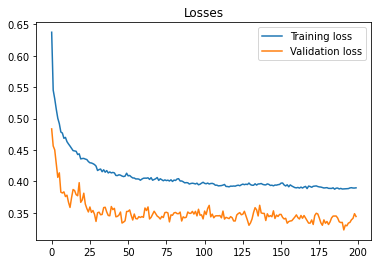

In [58]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [59]:
RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

RMSE error in test dataset is 1533.8060302734375


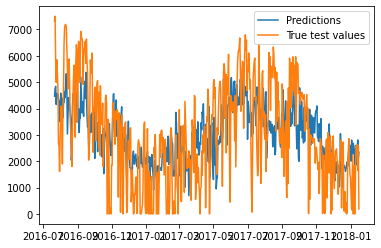

In [60]:
plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

In [69]:
bm_ff = future_features_func()

biom_future_lag1 = df_generated_biomass.iloc[-1].to_frame().T.drop(columns="value")
b = pd.DataFrame(scaler.fit_transform(biom_future_lag1.T).T, columns=biom_future_lag1.columns)

bm_ff = pd.concat([bm_ff.reset_index(), b], axis=1)
bm_ff = bm_ff.set_index("TIME")
bm_ff["week_of_year_53"] = 0

for i, date in enumerate(bm_ff.index):
    if i == 0:
        continue
    x = bm_ff.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    bm_ff.iat[i,107] = predictions[0]
    for j in range(2,102):
        bm_ff.iat[i,j+106] = bm_ff.iat[i-1, j+105]

bm_forecast = scaler.inverse_transform(bm_ff["lag1"].to_numpy().reshape(-1,1))
bm_f_df = pd.DataFrame(bm_forecast)
bm_f_df.to_csv("/content/drive/My Drive/Colab Notebooks/bm.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


# GEOTHERMAL

In [70]:
df = pd.read_csv(path, index_col="TIME")
df.index = pd.to_datetime(df.index)

if not df.index.is_monotonic:
    df = df.sort_index()

df_gm = df.rename(columns={"GEOTHERMAL": "value"})
df_gm = df_gm["value"].to_frame()

df_generated_gm = generate_time_lags(df_gm, 100)
df_generated_gm.head()

scaled_lagged_gm = scale(df_generated_gm)

gm_combined = pd.concat([df_features, scaled_lagged_gm.drop(columns="value")], axis=1)
gm_combined.dropna(inplace=True)


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(gm_combined, 'value', 0.2)

y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


[1/200] Training loss: 0.6545	 Validation loss: 0.4455
[2/200] Training loss: 0.5472	 Validation loss: 0.4259
[3/200] Training loss: 0.5358	 Validation loss: 0.4024
[4/200] Training loss: 0.5179	 Validation loss: 0.3855
[5/200] Training loss: 0.5112	 Validation loss: 0.3977
[6/200] Training loss: 0.4993	 Validation loss: 0.3849
[7/200] Training loss: 0.4897	 Validation loss: 0.3757
[8/200] Training loss: 0.4872	 Validation loss: 0.3862
[9/200] Training loss: 0.4782	 Validation loss: 0.3857
[10/200] Training loss: 0.4744	 Validation loss: 0.3850
[50/200] Training loss: 0.4130	 Validation loss: 0.3737
[100/200] Training loss: 0.3966	 Validation loss: 0.3446
[150/200] Training loss: 0.3923	 Validation loss: 0.3457
[200/200] Training loss: 0.3900	 Validation loss: 0.3361


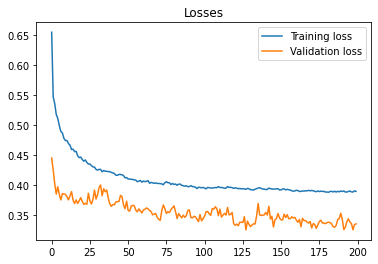

In [71]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

RMSE error in test dataset is 1533.8060302734375


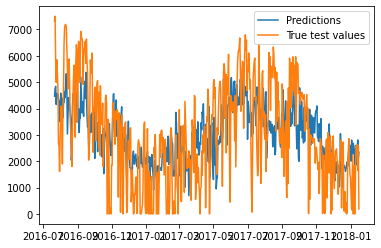

In [72]:
RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

In [73]:
gm_ff = future_features_func()

gm_future_lag1 = df_generated_gm.iloc[-1].to_frame().T.drop(columns="value")
g = pd.DataFrame(scaler.fit_transform(gm_future_lag1.T).T, columns=gm_future_lag1.columns)

gm_ff = pd.concat([gm_ff.reset_index(), g], axis=1)
gm_ff = gm_ff.set_index("TIME")
gm_ff["week_of_year_53"] = 0

for i, date in enumerate(gm_ff.index):
    if i == 0:
        continue
    x = gm_ff.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    gm_ff.iat[i,107] = predictions[0]
    for j in range(2,102):
        gm_ff.iat[i,j+106] = gm_ff.iat[i-1, j+105]

gm_forecast = scaler.inverse_transform(gm_ff["lag1"].to_numpy().reshape(-1,1))
gm_f_df = pd.DataFrame(gm_forecast)
gm_f_df.to_csv("/content/drive/My Drive/Colab Notebooks/gm.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


# SMALL HYDRO

In [74]:
df = pd.read_csv(path, index_col="TIME")
df.index = pd.to_datetime(df.index)

if not df.index.is_monotonic:
    df = df.sort_index()

df_sh = df.rename(columns={"SMALL HYDRO": "value"})
df_sh = df_sh["value"].to_frame()

df_generated_sh = generate_time_lags(df_sh, 100)
df_generated_sh.head()

scaled_lagged_sh = scale(df_generated_sh)

sh_combined = pd.concat([df_features, scaled_lagged_sh.drop(columns="value")], axis=1)
sh_combined.dropna(inplace=True)


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(sh_combined, 'value', 0.2)

y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


[1/200] Training loss: 0.6713	 Validation loss: 0.3802
[2/200] Training loss: 0.5653	 Validation loss: 0.3863
[3/200] Training loss: 0.5297	 Validation loss: 0.4121
[4/200] Training loss: 0.5157	 Validation loss: 0.4114
[5/200] Training loss: 0.5172	 Validation loss: 0.4228
[6/200] Training loss: 0.4951	 Validation loss: 0.3884
[7/200] Training loss: 0.4908	 Validation loss: 0.4057
[8/200] Training loss: 0.4846	 Validation loss: 0.3975
[9/200] Training loss: 0.4790	 Validation loss: 0.4034
[10/200] Training loss: 0.4776	 Validation loss: 0.3949
[50/200] Training loss: 0.4233	 Validation loss: 0.3715
[100/200] Training loss: 0.4029	 Validation loss: 0.3419
[150/200] Training loss: 0.3949	 Validation loss: 0.3553
[200/200] Training loss: 0.3922	 Validation loss: 0.3474


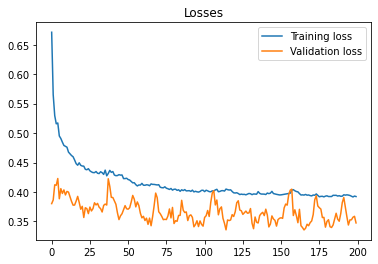

In [75]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

RMSE error in test dataset is 1533.8060302734375


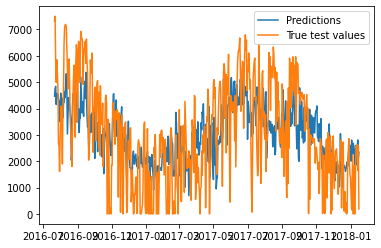

In [76]:
RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

In [77]:
sh_ff = future_features_func()

sh_future_lag1 = df_generated_sh.iloc[-1].to_frame().T.drop(columns="value")
s = pd.DataFrame(scaler.fit_transform(sh_future_lag1.T).T, columns=sh_future_lag1.columns)

sh_ff = pd.concat([sh_ff.reset_index(), s], axis=1)
sh_ff = sh_ff.set_index("TIME")
sh_ff["week_of_year_53"] = 0

for i, date in enumerate(sh_ff.index):
    if i == 0:
        continue
    x = sh_ff.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    sh_ff.iat[i,107] = predictions[0]
    for j in range(2,102):
        sh_ff.iat[i,j+106] = sh_ff.iat[i-1, j+105]

sh_forecast = scaler.inverse_transform(sh_ff["lag1"].to_numpy().reshape(-1,1))
sh_f_df = pd.DataFrame(sh_forecast)
sh_f_df.to_csv("/content/drive/My Drive/Colab Notebooks/sh.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


# WIND

In [78]:
df = pd.read_csv(path, index_col="TIME")
df.index = pd.to_datetime(df.index)

if not df.index.is_monotonic:
    df = df.sort_index()

df_w = df.rename(columns={"WIND TOTAL": "value"})
df_w = df_w["value"].to_frame()

df_generated_w = generate_time_lags(df_w, 100)
df_generated_w.head()

scaled_lagged_w = scale(df_generated_w)

w_combined = pd.concat([df_features, scaled_lagged_w.drop(columns="value")], axis=1)
w_combined.dropna(inplace=True)


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(w_combined, 'value', 0.2)

y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

batch_size = 64

train_features = torch.Tensor(X_train.values)
train_targets = torch.Tensor(y_train)
val_features = torch.Tensor(X_val.values)
val_targets = torch.Tensor(y_val)
test_features = torch.Tensor(X_test.values)
test_targets = torch.Tensor(y_test)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


[1/200] Training loss: 0.6447	 Validation loss: 0.3897
[2/200] Training loss: 0.5373	 Validation loss: 0.3632
[3/200] Training loss: 0.5193	 Validation loss: 0.3640
[4/200] Training loss: 0.5068	 Validation loss: 0.3595
[5/200] Training loss: 0.4981	 Validation loss: 0.3270
[6/200] Training loss: 0.4946	 Validation loss: 0.3301
[7/200] Training loss: 0.4816	 Validation loss: 0.3288
[8/200] Training loss: 0.4783	 Validation loss: 0.3345
[9/200] Training loss: 0.4726	 Validation loss: 0.3310
[10/200] Training loss: 0.4691	 Validation loss: 0.3372
[50/200] Training loss: 0.4066	 Validation loss: 0.3286
[100/200] Training loss: 0.3938	 Validation loss: 0.3076
[150/200] Training loss: 0.3918	 Validation loss: 0.3188
[200/200] Training loss: 0.3863	 Validation loss: 0.3087


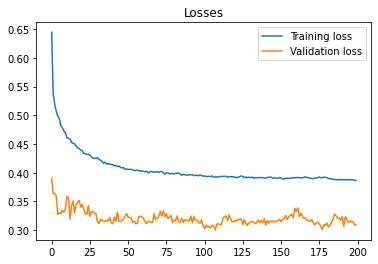

In [79]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6

model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, dropout_prob=dropout)
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

RMSE error in test dataset is 1533.8060302734375


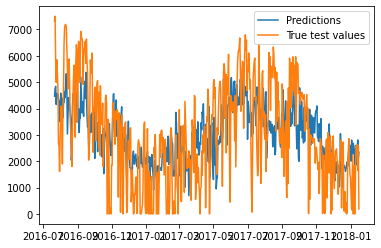

In [80]:
RMSE = mean_squared_error(df_result["prediction"], df_result["value"],squared = False)
print('RMSE error in test dataset is {RMSE}'.format(RMSE = RMSE))

plt.plot(df_result["prediction"], label="Predictions")
plt.plot(df_result["value"], label="True test values")
plt.legend()
plt.show()
plt.close()

In [81]:
w_ff = future_features_func()

w_future_lag1 = df_generated_w.iloc[-1].to_frame().T.drop(columns="value")
w = pd.DataFrame(scaler.fit_transform(w_future_lag1.T).T, columns=w_future_lag1.columns)

w_ff = pd.concat([w_ff.reset_index(), w], axis=1)
w_ff = w_ff.set_index("TIME")
w_ff["week_of_year_53"] = 0

for i, date in enumerate(w_ff.index):
    if i == 0:
        continue
    x = w_ff.iloc[i - 1]
    # predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    test = TensorDataset(torch.tensor(x, dtype=torch.float).unsqueeze(0), torch.tensor([1]).unsqueeze(0))
    load = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions, _ = opt.evaluate(load, batch_size=1, n_features=input_dim)
    w_ff.iat[i,107] = predictions[0]
    for j in range(2,102):
        w_ff.iat[i,j+106] = w_ff.iat[i-1, j+105]

w_forecast = scaler.inverse_transform(w_ff["lag1"].to_numpy().reshape(-1,1))
w_f_df = pd.DataFrame(w_forecast)
w_f_df.to_csv("/content/drive/My Drive/Colab Notebooks/w.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


# Forecasts

In [155]:
path = "/content/drive/My Drive/Colab Notebooks/forecasts_mk.csv"
forecasts = pd.read_csv(path, index_col="TIME")
forecasts.index = pd.to_datetime(forecasts.index)
if not forecasts.index.is_monotonic:
    forecasts = forecasts.sort_index()

forecasts.dropna(inplace=True)
forecasts

,BIOGAS,BIOMASS,GEOTHERMAL,SMALL HYDRO,SOLAR,WIND TOTAL
TIME,,,,,,
2018-01-16,5737.328084,7795.035740,23135.62839,10156.363020,2568.570378,7429.557231
2018-01-17,5521.940534,7886.547990,22427.84376,0.487441,2178.765872,14099.748220
2018-01-18,5448.829683,7717.088273,23047.38775,8895.577795,1668.459391,11060.624280
2018-01-19,5444.351382,7895.032949,22424.54525,8762.958979,1941.249460,5154.918295
2018-01-20,5391.204496,7895.133634,22332.60812,8730.453669,1833.278828,5962.875402
...,...,...,...,...,...,...
2021-01-27,5422.515459,7699.882417,22024.26918,8553.307384,1513.506015,5706.822000
2021-01-28,5449.354820,7750.483292,22103.66868,8298.224165,2014.065492,4633.169965
2021-01-29,5477.821332,7804.151838,22290.02817,8496.451639,1958.990324,7136.180539


In [156]:
f_wk = (
    forecasts
    .assign(week_of_year = forecasts.index.weekofyear)
    .assign(year = forecasts.index.year)
)
f_wk.loc[:, "year"] = f_wk["year"].apply(lambda x: x - 2018)
f_wk["week_of_year"] = f_wk["week_of_year"]
f_wk["week"] = f_wk["week_of_year"] + 52*f_wk["year"]

f_wk = f_wk.drop(columns=["week_of_year", "year"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
weekly = f_wk.groupby("week").mean()
weekly.drop(weekly.tail(1).index,inplace=True)
weekly

,BIOGAS,BIOMASS,GEOTHERMAL,SMALL HYDRO,SOLAR,WIND TOTAL
week,,,,,,
1,5450.365942,7746.680100,22219.066770,9023.104589,2062.055059,6535.649071
3,5490.832262,7847.248154,22632.676200,7555.529620,1986.396918,7441.087172
4,5380.669229,7846.758535,22165.492650,8852.248552,1741.177276,1983.460272
5,5543.073426,7880.476946,22451.176140,9639.712441,2017.349990,7355.847689
6,5577.954166,8082.686015,22624.057429,10118.796209,2352.132267,10410.110728
...,...,...,...,...,...,...
156,5479.413845,7807.153911,22417.374810,9035.053653,2020.417027,6560.848554
157,5446.694195,7745.467004,22630.366092,8915.424873,1986.798797,5935.957658
158,5436.853403,7726.913954,22313.101277,8582.294890,1911.076981,6597.511868


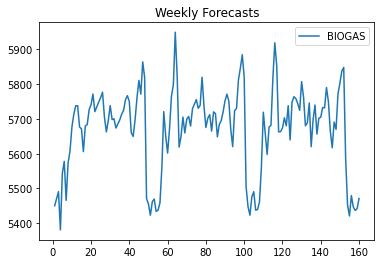

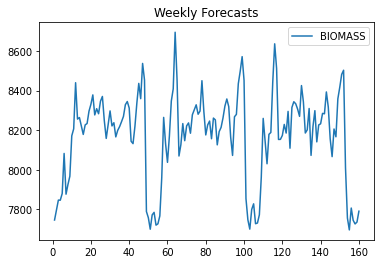

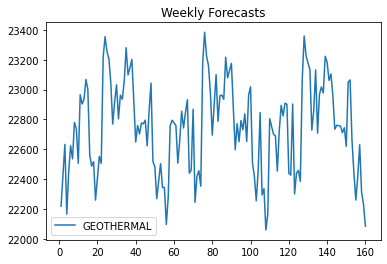

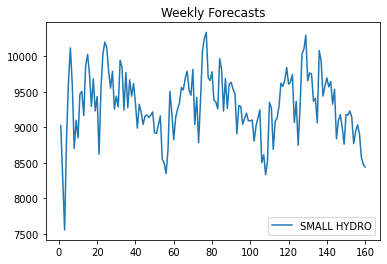

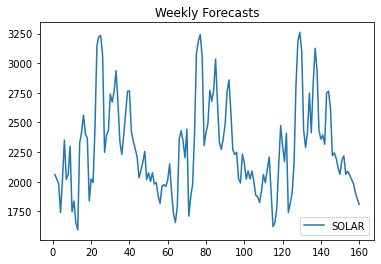

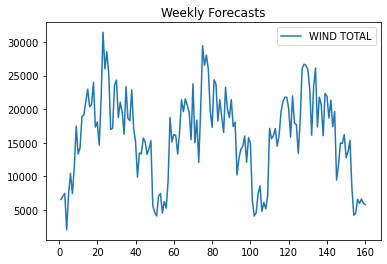

In [171]:
plt.plot(weekly["BIOGAS"], label="BIOGAS")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

plt.plot(weekly["BIOMASS"], label="BIOMASS")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

plt.plot(weekly["GEOTHERMAL"], label="GEOTHERMAL")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

plt.plot(weekly["SMALL HYDRO"], label="SMALL HYDRO")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

plt.plot(weekly["SOLAR"], label="SOLAR")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

plt.plot(weekly["WIND TOTAL"], label="WIND TOTAL")
plt.legend()
plt.title("Weekly Forecasts")
plt.show()
plt.close()

In [160]:
f_mon = (
    forecasts
    .assign(month = forecasts.index.month)
    .assign(year = forecasts.index.year)
)
f_mon.loc[:, "year"] = f_mon["year"].apply(lambda x: x - 2018)
f_mon["months"] = f_mon["month"] + 12*f_mon["year"]
f_mon = f_mon.drop(columns=["month", "year"])

In [163]:
monthly = f_mon.groupby("months").mean()

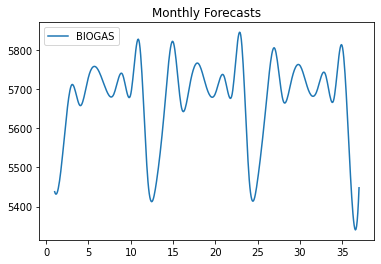

In [170]:
from scipy.interpolate import interp1d
x = monthly.index.to_numpy()
y = monthly["BIOGAS"]

x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)

plt.plot(x_new,y_new, label="BIOGAS")
plt.legend()
plt.title("Monthly Forecasts")
plt.show()
plt.close()

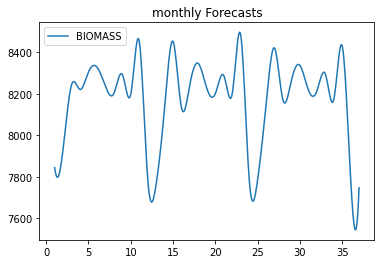

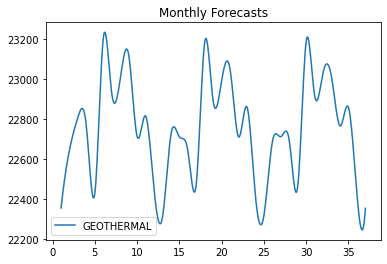

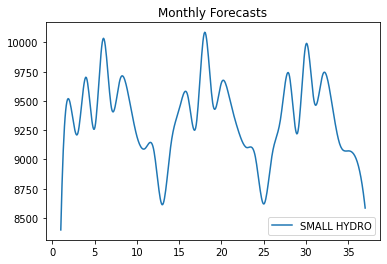

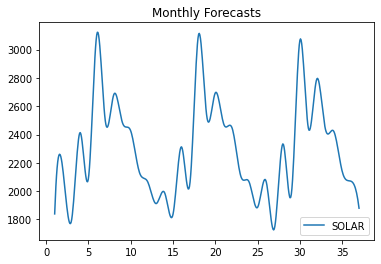

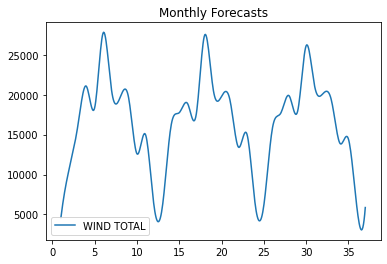

In [172]:
y = monthly["BIOMASS"]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)
plt.plot(x_new,y_new, label="BIOMASS")
plt.legend()
plt.title("monthly Forecasts")
plt.show()
plt.close()

y = monthly["GEOTHERMAL"]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)
plt.plot(x_new,y_new, label="GEOTHERMAL")
plt.legend()
plt.title("Monthly Forecasts")
plt.show()
plt.close()

y = monthly["SMALL HYDRO"]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)
plt.plot(x_new,y_new, label="SMALL HYDRO")
plt.legend()
plt.title("Monthly Forecasts")
plt.show()
plt.close()

y = monthly["SOLAR"]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)
plt.plot(x_new,y_new, label="SOLAR")
plt.legend()
plt.title("Monthly Forecasts")
plt.show()
plt.close()

y = monthly["WIND TOTAL"]
x_new = np.linspace(x.min(), x.max(),500)
f = interp1d(x, y, kind='cubic')
y_new = f(x_new)
plt.plot(x_new,y_new, label="WIND TOTAL")
plt.legend()
plt.title("Monthly Forecasts")
plt.show()
plt.close()

In [173]:
monthly.to_csv("/content/drive/My Drive/Colab Notebooks/monthly_forecasts_mk.csv")